# Pancreas Development

## Check jupyter notebook

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.5.0
ipykernel        : 6.15.2
ipywidgets       : 8.0.2
jupyter_client   : 7.3.5
jupyter_core     : 4.11.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.6.7
nbconvert        : 7.0.0
nbformat         : 5.4.0
notebook         : 6.4.12
qtconsole        : not installed
traitlets        : 5.3.0


## Load modules

In [2]:
%load_ext autoreload
%autoreload 2
import scvelo as scv
import numpy as np
import torch
import matplotlib.pyplot as plt
from pyrovelocity.data import load_data
from scipy.stats import spearmanr, pearsonr
from pyrovelocity.api import train_model
import seaborn as sns
import pandas as pd
from pyrovelocity.plot import plot_posterior_time, plot_gene_ranking,\
      vector_field_uncertainty, plot_vector_field_uncertain,\
      plot_mean_vector_field, project_grid_points,rainbowplot,denoised_umap,\
      us_rainbowplot, plot_arrow_examples
from pyrovelocity.utils import mae, mae_evaluate

In [3]:
adata = load_data(top_n=2000, min_shared_counts=30)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [4]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'u_lib_size_raw', 's_lib_size_raw', 'gcs', 'cytotrace', 'counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'cytotrace', 'cytotrace_corrs', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'loss'
    layers: 'Ms', 'Mu', 'fit

## Apply Model 1 to training and validation cells in pancreas

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 3696 cells, 2000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3696  │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
│    cytotrace     │    adata.obs['cytotrace']     │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
step    0 loss = 9.01336e+07 patience = 45
step  100 loss = 6.57153e+07 patience = 45
step  200 loss = 5.46784e+07 patience = 45
step  300 loss = 4.53023e+07 patience = 45
step  400 loss = 3.71664e+07 patience = 45
step  500 loss = 3.00779e+07 patience = 45
step  600 loss = 2.39203e+07 patience = 45
step  700 loss = 1.87633e+07 patience = 45
step  800 loss = 1.4903e+07 patience = 45
step  900 loss = 1.24599e+07 patience = 45
step 1000 loss = 1.14886e+07 patience = 45
step 1100 loss = 1.12743e+07 patience = 45
step 1200 loss = 1.11933e+07 patience = 44
step 1300 loss = 1.11422e+07 patience = 45
step 1400 loss = 1.10905e+07 patience = 44
step 1500 loss = 1.10555e+07 patience = 44
step 1600 loss = 1.10037e+07 patience = 45
step 1700 loss = 1.0964e+07 patience = 45
step 1800 loss = 1.09394e+07 patience = 45
step 1900 loss = 1.09002e+07 patience = 44
step 2000 loss = 1.08785e+07 patience = 44
step 2100 loss = 1.08635e+07 patience = 45
step 2200 loss = 1.0

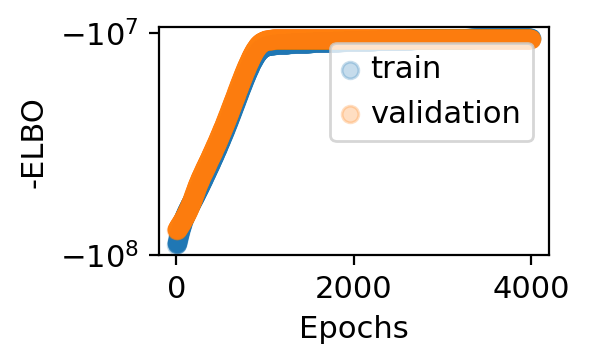

In [5]:
adata_model_pos_split = train_model(adata, max_epochs=4000, svi_train=False, log_every=100,
                                    patient_init=45, batch_size=-1, use_gpu=1,
                                    include_prior=True, offset=False, library_size=True,
                                    patient_improve=1e-4, guide_type='auto_t0_constraint', train_size=0.67)

                    MAE
label                  
Poisson train  0.512080
Poisson valid  0.517524


,MAE,label
0,0.511755,Poisson train
1,0.512193,Poisson train
2,0.511711,Poisson train
3,0.512358,Poisson train
4,0.512323,Poisson train
5,0.511926,Poisson train
6,0.512204,Poisson train
7,0.512150,Poisson train
8,0.511319,Poisson train
9,0.512367,Poisson train


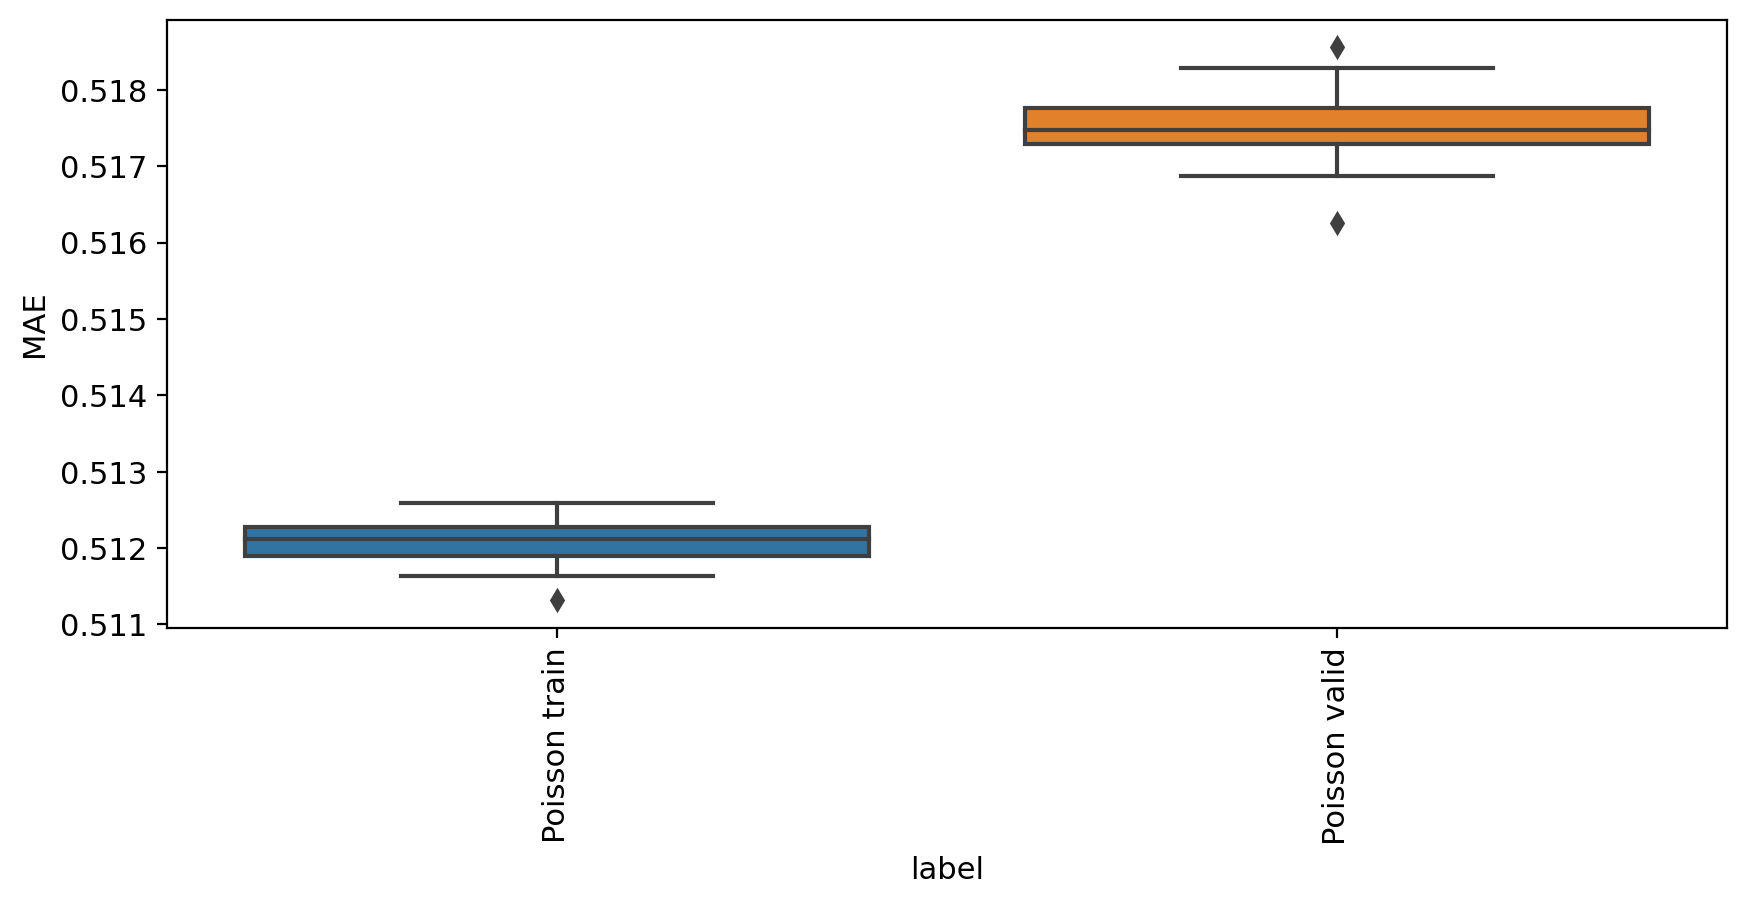

In [6]:
mae_evaluate(adata_model_pos_split, adata)

## Apply Model 1 to all cells

INFO     No batch_key inputted, assuming all cells are same batch                                                  


INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 3696 cells, 2000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 3696 cells, 2000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3696  │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
│    cytotrace     │    adata.obs['cytotrace']     │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto_t0_constraint
TraceEnum
step    0 loss = 6.0886 patience = 45
step  100 loss = 4.43704 patience = 45
step  200 loss = 3.68965 patience = 45
step  300 loss = 3.05238 patience = 45
step  400 loss = 2.5054 patience = 45
step  500 loss = 2.02754 patience = 45
step  600 loss = 1.61279 patience = 45
step  700 loss = 1.26498 patience = 45
step  800 loss = 1.00527 patience = 45
step  900 loss = 0.841162 patience = 45
step 1000 loss = 0.775899 patience = 45
step 1100 loss = 0.761546 patience = 45
step 1200 loss = 0.755562 patience = 45
step 1300 loss = 0.751937 patience = 45
step 1400 loss = 0.748457 patience = 44
step 1500 loss = 0.745993 patience = 44
step 1600 loss = 0.741952 patience = 44
step 1700 loss = 0.739086 patience = 45
step 1800 loss = 0.73718 patience = 44
step 1900 loss = 0.734106 patience = 44
step 2000 loss = 0.732198 patience = 41
step 2100 loss = 0.730901 patience = 45
step 2200 loss = 0.72865 patience = 44
step 2300 loss = 0.724907 patience = 43
step 24

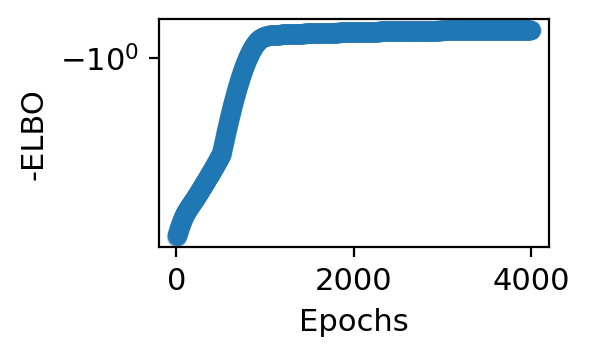

In [7]:
adata_model_pos = train_model(adata, max_epochs=4000, svi_train=False, log_every=100,
                              patient_init=45, batch_size=-1, use_gpu=0,
                              include_prior=True, offset=False, library_size=True,
                              patient_improve=1e-4, guide_type='auto_t0_constraint', train_size=1.0)

                        MAE
label                      
Poisson all cells  0.512289


,MAE,label
0,0.512249,Poisson all cells
1,0.512128,Poisson all cells
2,0.512294,Poisson all cells
3,0.512348,Poisson all cells
4,0.512621,Poisson all cells
5,0.512312,Poisson all cells
6,0.512039,Poisson all cells
7,0.512519,Poisson all cells
8,0.511786,Poisson all cells
9,0.512624,Poisson all cells


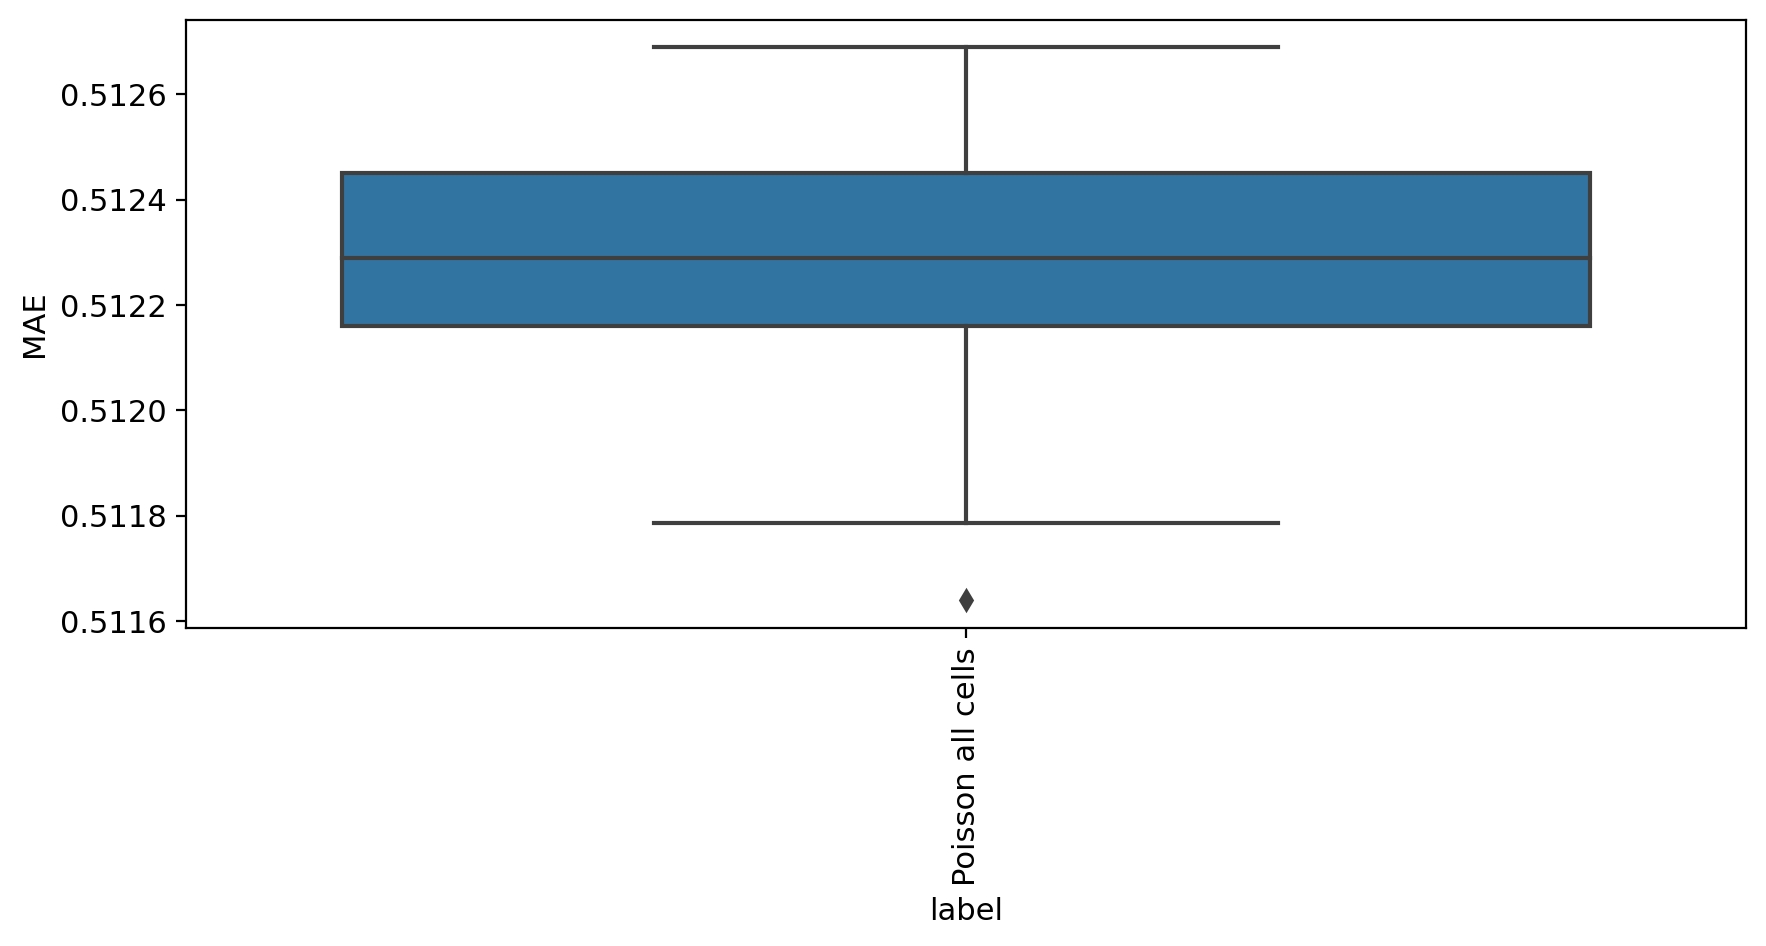

In [8]:
mae_evaluate(adata_model_pos[1], adata)

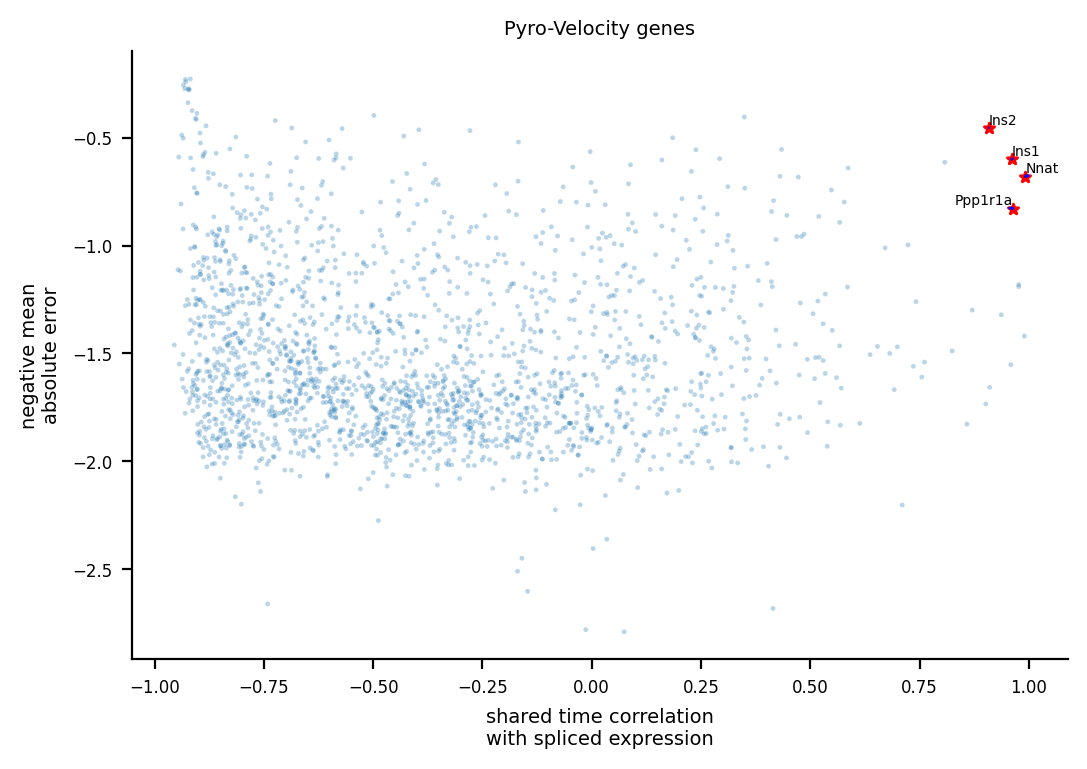

In [9]:
fig, ax = plt.subplots()
volcano_data, _ = plot_gene_ranking([adata_model_pos[1]], [adata], ax=ax, time_correlation_with='st')

In [10]:
v_map_all, embeds_radian, fdri = vector_field_uncertainty(adata, adata_model_pos[1], basis='umap', n_jobs=10)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 10/256 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)


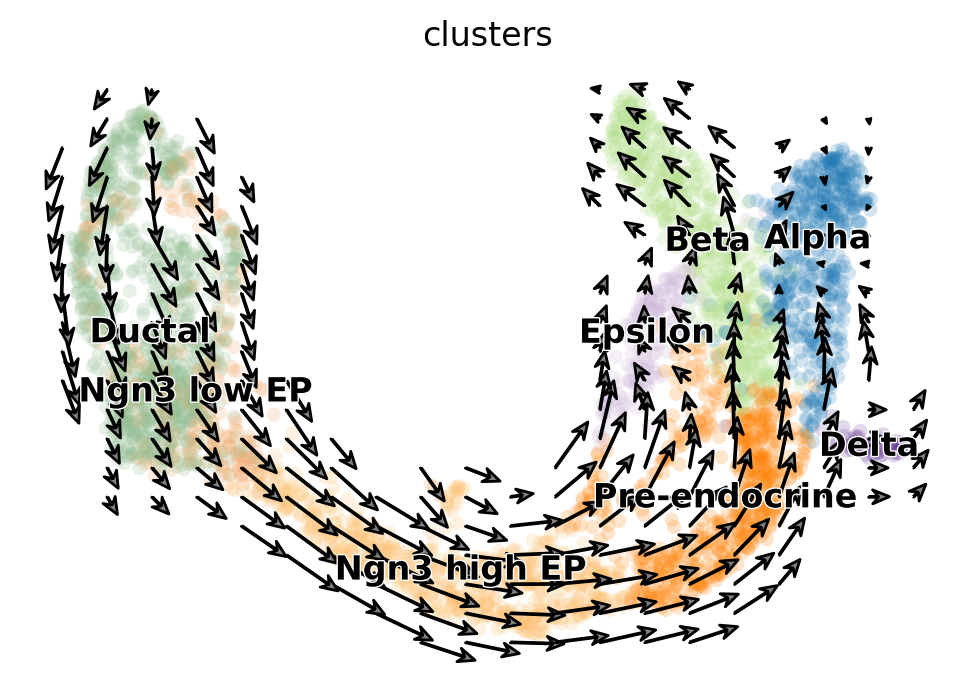

In [11]:
fig, ax = plt.subplots()
embed_mean = plot_mean_vector_field(adata_model_pos[1], adata, ax=ax, n_jobs=10)

## Assemble figure

V_grid.........
V_grid.........
60 50 40
0.0
SpearmanrResult(correlation=0.9495828538437237, pvalue=0.0)
Nnat
[ 9.455868   1.4856936  9.129604  ...  1.6113306 15.078645  10.98976  ]
Ppp1r1a
[ 9.455868   1.4856936  9.129604  ...  1.6113306 15.078645  10.98976  ]
Ins1
[ 9.455868   1.4856936  9.129604  ...  1.6113306 15.078645  10.98976  ]
Ins2
[ 9.455868   1.4856936  9.129604  ...  1.6113306 15.078645  10.98976  ]


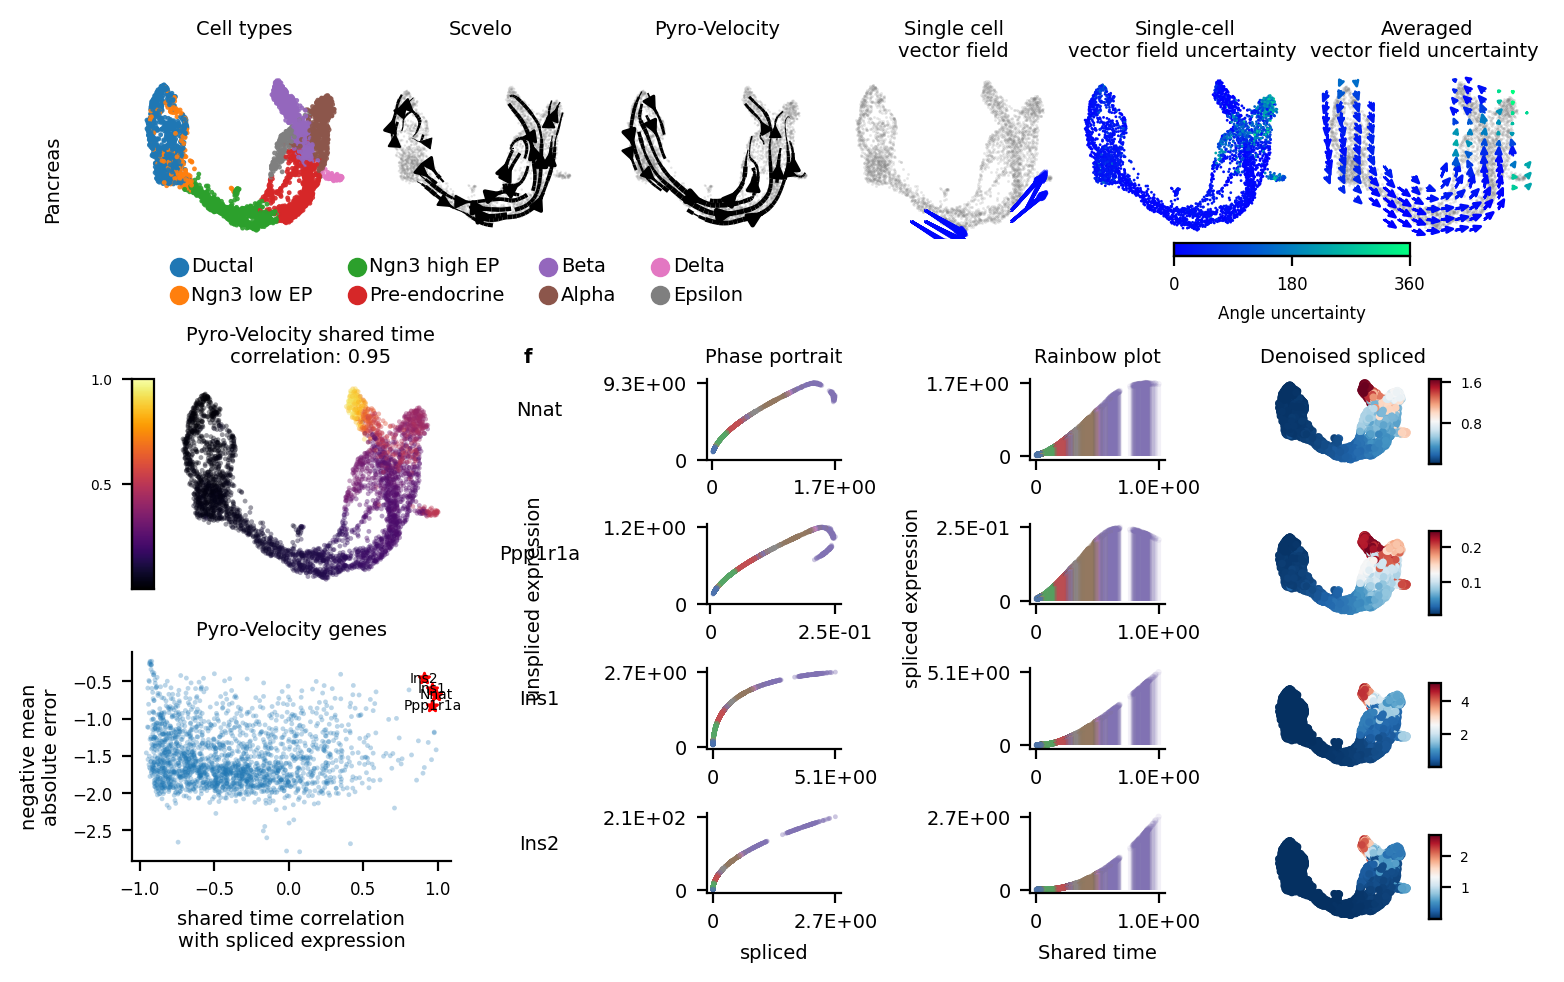

In [12]:
fig = plt.figure(figsize=(7.07, 4.5))
subfig_A = fig.subfigures(2, 1, wspace=0.0, hspace=0, height_ratios=[1.2, 3])
dot_size = 3
font_size = 7

ress = pd.DataFrame({"cell_type": adata.obs['clusters'].values,
                     "X1": adata.obsm['X_umap'][:,0],
                     "X2": adata.obsm['X_umap'][:,1]})
subfig_A0 = subfig_A[0].subfigures(1, 2, wspace=0.0, hspace=0, width_ratios=[4, 2])

ax = subfig_A0[0].subplots(1, 4)
sns.scatterplot(x='X1', y='X2', data=ress, alpha=0.9, s=dot_size,
                linewidth=0, edgecolor="none", hue='cell_type',
                ax=ax[0], legend='brief')
ax[0].axis('off')
ax[0].set_title("Cell types\n", fontsize=font_size)
ax[0].legend(bbox_to_anchor=[2.9, -0.01], ncol=4, prop={'size': font_size}, fontsize=font_size, frameon=False)
kwargs = dict(color='gray', density=.8, add_margin=.1, s=dot_size,
              show=False, alpha=.2, min_mass=3.5, frameon=False)
scv.pl.velocity_embedding_stream(adata, fontsize=font_size, ax=ax[1], title='', **kwargs)
ax[1].set_title("Scvelo\n", fontsize=7)

scv.pl.velocity_embedding_stream(adata, fontsize=font_size, basis='umap',
                                 title='', ax=ax[2], vkey='velocity_pyro', **kwargs)
ax[2].set_title("Pyro-Velocity\n", fontsize=7)

# plot_arrow_examples(adata_train, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
#                     n_sample=30, fig=fig, basis='umap', scale=0.004, alpha=0.18)
plot_arrow_examples(adata, np.transpose(v_map_all, (1, 2, 0)), embeds_radian, ax=ax[3],
                    n_sample=30, fig=fig, basis='umap', scale=0.008, alpha=0.2, index=5,
                    scale2=0.015, num_certain=6)
ax[3].set_title("Single cell\nvector field", fontsize=7)

plot_vector_field_uncertain(adata, embed_mean, embeds_radian,
                            fig=subfig_A0[1], cbar=True, basis='umap', scale=0.05)

subfig_A0[0].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.35)
subfig_A0[1].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.35)

subfig_A[0].text(-0.06, 0.58, "Pancreas", size=7, rotation="vertical", va="center")

subfig_B = subfig_A[1].subfigures(1, 2, wspace=0.0, hspace=0, width_ratios=[1.6, 4])
##subfig_B[0].subplots_adjust(hspace=0.2, wspace=0.1, left=0.01, right=0.99, top=0.99, bottom=0.1)

ax = subfig_B[0].subplots(2, 1)
plot_posterior_time(adata_model_pos[1], adata, ax=ax[0], fig=subfig_B[0], addition=False)
subfig_B[0].subplots_adjust(hspace=0.3, wspace=0.1, left=0.01, right=0.8, top=0.92, bottom=0.17)

volcano_data2, _ = plot_gene_ranking([adata_model_pos[1]], [adata], ax=ax[1],
                                    time_correlation_with='st', assemble=True)
_ = rainbowplot(volcano_data2, adata, adata_model_pos[1], subfig_B[1], data=['st', 'ut'], num_genes=4)

In [13]:
fig.savefig("pancreas_output_figure1.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)

V_grid.........
60 50 40


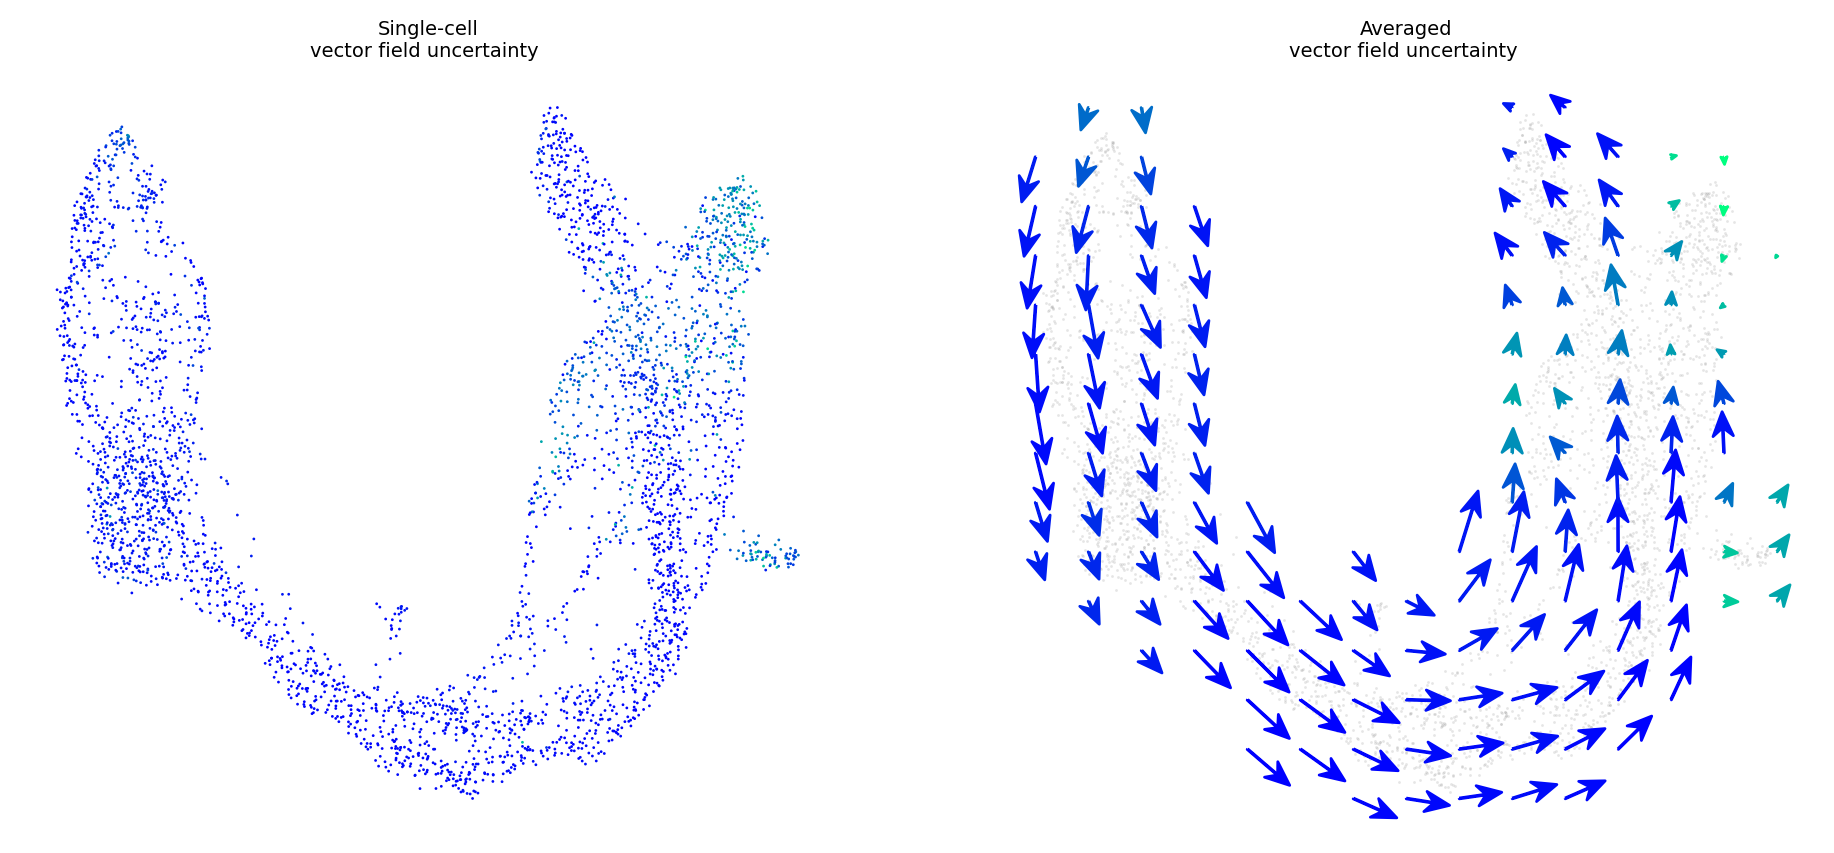

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.5, 5)
plot_vector_field_uncertain(adata, embed_mean, embeds_radian,
                            ax=ax,
                            fig=fig, cbar=False, basis='umap', scale=0.05)

## More uncertainty evaluation metrics

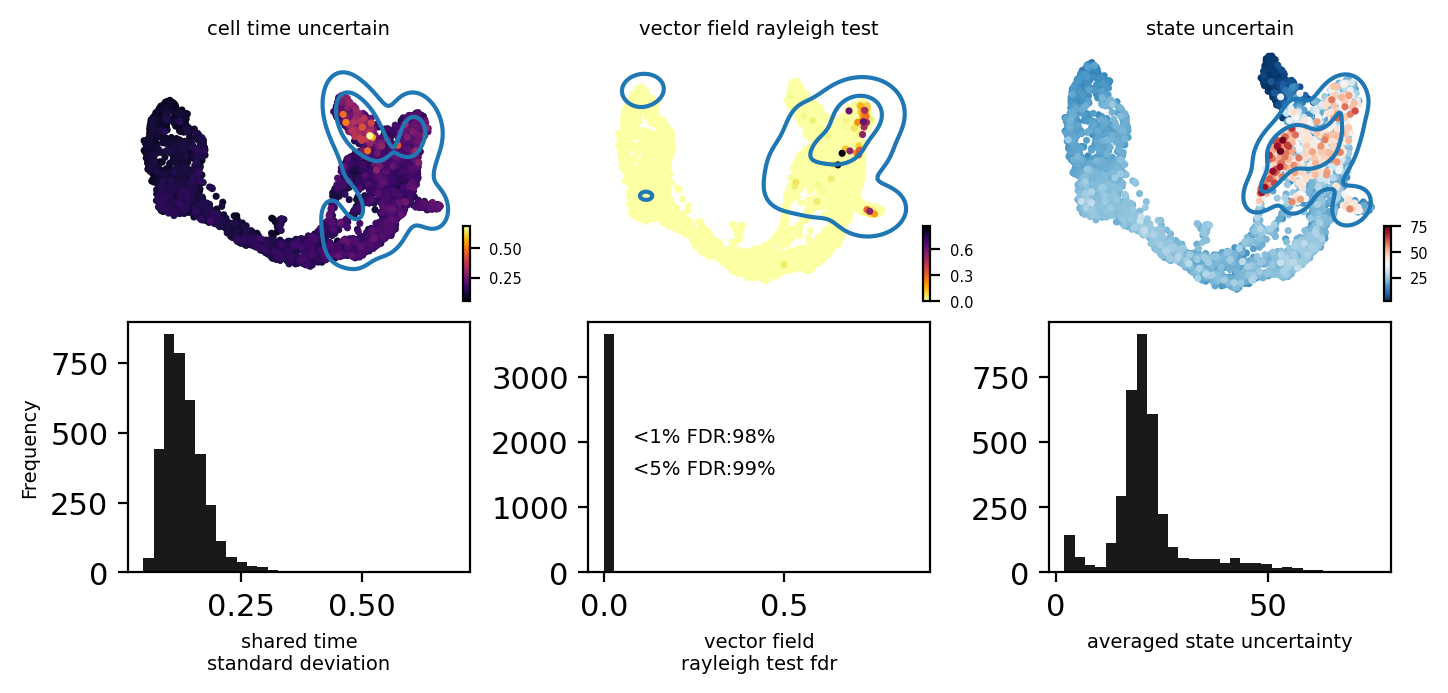

In [15]:
from pyrovelocity.plot import plot_state_uncertainty
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(7.07, 3.5)
pos = adata_model_pos[1]
bin = 30
adata.obs['cell_time_uncertain'] = adata_model_pos[1]['cell_time'].std(0).flatten()
scv.pl.scatter(adata, c='cell_time_uncertain', ax=ax[0][0], show=False, cmap='inferno', fontsize=7)

_ = ax[1][0].hist(adata.obs.cell_time_uncertain, bins=bin, color='black', alpha=0.9)
ax[1][0].set_xlabel("shared time\nstandard deviation", fontsize=7)
select = adata.obs['cell_time_uncertain'] > np.quantile(adata.obs['cell_time_uncertain'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][0], levels=3, fill=False)

adata.obs['vector_field_rayleigh_test'] = fdri
scv.pl.scatter(adata, c='vector_field_rayleigh_test', ax=ax[0][1], show=False, cmap='inferno_r', fontsize=7)
select = adata.obs['vector_field_rayleigh_test'] > np.quantile(adata.obs['vector_field_rayleigh_test'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][1], levels=3, fill=False)

_ = ax[1][1].hist(adata.obs.vector_field_rayleigh_test, bins=bin, color='black', alpha=0.9)
ax[1][1].set_xlabel("vector field\nrayleigh test fdr", fontsize=7)
ax[1][1].text(0.08, 2000, "<1%% FDR:%s%%" % int((fdri < 0.01).sum()/fdri.shape[0]*100), fontsize=7)
ax[1][1].text(0.08, 1500, "<5%% FDR:%s%%" % int((fdri < 0.05).sum()/fdri.shape[0]*100), fontsize=7)

fig.subplots_adjust(hspace=0.3, wspace=0.7, left=0.01, right=0.8, top=0.92, bottom=0.17)
plot_state_uncertainty(pos, adata, kde=False, data='denoised', top_percentile=0.9, ax=ax[0][2])

_ = ax[1][2].hist(adata.obs['state_uncertain'], bins=bin, color='black', alpha=0.9)
ax[1][2].set_xlabel("averaged state uncertainty", fontsize=7)
select = adata.obs['state_uncertain'] > np.quantile(adata.obs['state_uncertain'], 0.9)
sns.kdeplot(adata.obsm['X_umap'][:, 0][select],
            adata.obsm['X_umap'][:, 1][select], ax=ax[0][2], levels=3, fill=False)

ax[1][0].set_ylabel("Frequency", fontsize=7)
fig.tight_layout()

In [16]:
fig.savefig("pancreas_output_figure2.tif", facecolor=fig.get_facecolor(), bbox_inches='tight', edgecolor='none', dpi=300)
